In [2]:
!git clone --branch experiments https://github.com/vlwk/TextAttack.git

Cloning into 'TextAttack'...
remote: Enumerating objects: 24124, done.
remote: Counting objects: 100% (2506/2506), done.
remote: Compressing objects: 100% (866/866), done.
remote: Total 24124 (delta 1127), reused 2106 (delta 978), pack-reused 21618 (from 3)
Receiving objects: 100% (24124/24124), 52.00 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (16987/16987), done.


In [3]:
%cd TextAttack
!pip install -e .
!git pull origin experiments
%cd imperceptible_experiments

/content/TextAttack
Obtaining file:///content/TextAttack
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 63.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [3]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [4]:
from finetune_scripts.sc_t.bhadresh_ft.train import main
main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Epoch 1/3


Training: 100%|██████████| 4500/4500 [03:04<00:00, 24.36it/s]


Validation Accuracy: 0.9317
New best model saved at models/bhadresh_ft/checkpoints

Epoch 2/3


Training: 100%|██████████| 4500/4500 [03:03<00:00, 24.48it/s]


Validation Accuracy: 0.9511
New best model saved at models/bhadresh_ft/checkpoints

Epoch 3/3


Training: 100%|██████████| 4500/4500 [03:03<00:00, 24.46it/s]


Validation Accuracy: 0.9566
New best model saved at models/bhadresh_ft/checkpoints

Training complete. Best Accuracy: 0.9566


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model pushed to https://huggingface.co/vlwk/bhadresh-ft-enc


In [7]:
import os
import ast
import json
import torch
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel
from torch import nn
from tqdm import tqdm

# === CONFIG ===
MODEL_ID = "vlwk/bhadresh-ft-enc"
TEST_PATH = "datasets/sc_o/emotion_perturbed/files/test_annotated/deletions_full_1to10_test_annotated.csv"
OUTPUT_CSV = "results/sc_o/emotion_perturbed/bhadresh_ft_enc/cls_cosine_deletions.csv"
BATCH_SIZE = 32
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

# === DATASET ===
class DualInputDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.perturbed = df["input"].tolist()
        self.clean = df["original_text"].tolist()
        self.word_indices = [ast.literal_eval(x) for x in df["word_indices_perturbed"]]
        self.word_indices_clean = [ast.literal_eval(x) for x in df["word_indices_clean"]]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.perturbed)

    def __getitem__(self, i):
        perturbed_tokens = self.tokenizer(self.perturbed[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        clean_tokens = self.tokenizer(self.clean[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return {
            "pert_input_ids": perturbed_tokens["input_ids"].squeeze(0),
            "pert_mask": perturbed_tokens["attention_mask"].squeeze(0),
            "clean_input_ids": clean_tokens["input_ids"].squeeze(0),
            "clean_mask": clean_tokens["attention_mask"].squeeze(0),
            "word_indices": self.word_indices[i],
            "word_indices_clean": self.word_indices_clean[i],
            "perturbed_text": self.perturbed[i],
            "clean_text": self.clean[i],
        }

def custom_collate_fn(batch):
    return {
        key: torch.stack([b[key] for b in batch]) if isinstance(batch[0][key], torch.Tensor)
        else [b[key] for b in batch] for key in batch[0]
    }

# === MODEL ===
class WordEncoder(nn.Module):
    def __init__(self, base_model, hidden_size=768, num_labels=6):
        super().__init__()
        self.encoder = base_model
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4),
            num_layers=6
        )
        self.classifier = nn.Linear(hidden_size, num_labels)  # <--- THIS LINE FIXES THE ERROR

    def get_cls(self, input_ids, attention_mask, word_indices):
        hidden = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        cls = hidden[:, 0, :]
        batch_size, seq_len, hidden_size = hidden.shape
        word_embeds = []
        for i in range(batch_size):
            vecs = []
            for group in word_indices[i]:
                if all(idx < seq_len for idx in group):
                    vecs.append(hidden[i, group].mean(dim=0))
            w = torch.stack(vecs) if vecs else torch.zeros((1, hidden_size), device=hidden.device)
            w = torch.cat([cls[i].unsqueeze(0), w], dim=0)
            word_embeds.append(w)

        padded = nn.utils.rnn.pad_sequence(word_embeds, batch_first=True)
        transformed = self.transformer(padded)
        pooled = transformed[:, 0, :]
        return pooled  # Just return the CLS-like embedding


# === MAIN ===
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_ID)
    base_model = DistilBertModel.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")
    model = WordEncoder(base_model).to(device)
    model.load_state_dict(torch.hub.load_state_dict_from_url(
        f"https://huggingface.co/{MODEL_ID}/resolve/main/model.pt", map_location=device
    ))
    model.eval()

    df = pd.read_csv(TEST_PATH)
    dataset = DualInputDataset(df, tokenizer)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

    rows = []
    with torch.no_grad():
        for batch in tqdm(loader):
            p_ids = batch["pert_input_ids"].to(device)
            p_mask = batch["pert_mask"].to(device)
            c_ids = batch["clean_input_ids"].to(device)
            c_mask = batch["clean_mask"].to(device)

            p_indices = batch["word_indices"]
            c_indices = batch["word_indices_clean"]

            emb_p = model.get_cls(p_ids, p_mask, p_indices)
            emb_c = model.get_cls(c_ids, c_mask, c_indices)

            sims = F.cosine_similarity(emb_p, emb_c, dim=-1).cpu().tolist()

            for i in range(len(sims)):
                rows.append({
                    "perturbed_text": batch["perturbed_text"][i],
                    "clean_text": batch["clean_text"][i],
                    "cosine_similarity": sims[i]
                })

    pd.DataFrame(rows).to_csv(OUTPUT_CSV, index=False)
    print(f"Saved cosine similarities to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


100%|██████████| 63/63 [00:11<00:00,  5.62it/s]

Saved cosine similarities to results/sc_o/emotion_perturbed/bhadresh_ft_enc/cls_cosine_deletions.csv


In [9]:
import os
import ast
import torch
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# === CONFIG ===
MODEL_ID = "vlwk/bhadresh-ft"
TEST_PATH = "datasets/sc_o/emotion_perturbed/files/test_annotated/deletions_full_1to10_test_annotated.csv"
OUTPUT_CSV = "results/sc_o/emotion_perturbed/bhadresh_ft/cls_cosine_deletions.csv"
BATCH_SIZE = 32
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

# === DATASET ===
class DualInputDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.perturbed = df["input"].tolist()
        self.clean = df["original_text"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.perturbed)

    def __getitem__(self, i):
        pert_tokens = self.tokenizer(self.perturbed[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        clean_tokens = self.tokenizer(self.clean[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return {
            "pert_input_ids": pert_tokens["input_ids"].squeeze(0),
            "pert_mask": pert_tokens["attention_mask"].squeeze(0),
            "clean_input_ids": clean_tokens["input_ids"].squeeze(0),
            "clean_mask": clean_tokens["attention_mask"].squeeze(0),
            "perturbed_text": self.perturbed[i],
            "clean_text": self.clean[i],
        }

def custom_collate_fn(batch):
    return {
        key: torch.stack([b[key] for b in batch]) if isinstance(batch[0][key], torch.Tensor)
        else [b[key] for b in batch] for key in batch[0]
    }

# === MAIN ===
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_ID)
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_ID).to(device)
    model.eval()

    df = pd.read_csv(TEST_PATH)
    dataset = DualInputDataset(df, tokenizer)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

    rows = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating CLS similarity"):
            p_ids = batch["pert_input_ids"].to(device)
            p_mask = batch["pert_mask"].to(device)
            c_ids = batch["clean_input_ids"].to(device)
            c_mask = batch["clean_mask"].to(device)

            emb_p = model.distilbert(input_ids=p_ids, attention_mask=p_mask).last_hidden_state[:, 0, :]
            emb_c = model.distilbert(input_ids=c_ids, attention_mask=c_mask).last_hidden_state[:, 0, :]

            sims = F.cosine_similarity(emb_p, emb_c, dim=-1).cpu().tolist()

            for i in range(len(sims)):
                rows.append({
                    "perturbed_text": batch["perturbed_text"][i],
                    "clean_text": batch["clean_text"][i],
                    "cosine_similarity": sims[i]
                })

    pd.DataFrame(rows).to_csv(OUTPUT_CSV, index=False)
    print(f"Saved cosine similarities to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Evaluating CLS similarity: 100%|██████████| 63/63 [00:04<00:00, 15.48it/s]

Saved cosine similarities to results/sc_o/emotion_perturbed/bhadresh_ft/cls_cosine_deletions.csv


In [11]:
import os
import torch
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# === CONFIG ===
MODEL_ID = "bhadresh-savani/distilbert-base-uncased-emotion"
TEST_PATH = "datasets/sc_o/emotion_perturbed/files/test_annotated/deletions_full_1to10_test_annotated.csv"
OUTPUT_CSV = "results/sc_o/emotion_perturbed/bhadresh_orig/cls_cosine_deletions.csv"
BATCH_SIZE = 32
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

# === DATASET ===
class DualInputDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.perturbed = df["input"].tolist()
        self.clean = df["original_text"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.perturbed)

    def __getitem__(self, i):
        pert_tokens = self.tokenizer(self.perturbed[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        clean_tokens = self.tokenizer(self.clean[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return {
            "pert_input_ids": pert_tokens["input_ids"].squeeze(0),
            "pert_mask": pert_tokens["attention_mask"].squeeze(0),
            "clean_input_ids": clean_tokens["input_ids"].squeeze(0),
            "clean_mask": clean_tokens["attention_mask"].squeeze(0),
            "perturbed_text": self.perturbed[i],
            "clean_text": self.clean[i],
        }

def custom_collate_fn(batch):
    return {
        key: torch.stack([b[key] for b in batch]) if isinstance(batch[0][key], torch.Tensor)
        else [b[key] for b in batch] for key in batch[0]
    }

# === MAIN ===
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_ID)
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_ID).to(device)
    model.eval()

    df = pd.read_csv(TEST_PATH)
    dataset = DualInputDataset(df, tokenizer)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

    rows = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating CLS similarity"):
            p_ids = batch["pert_input_ids"].to(device)
            p_mask = batch["pert_mask"].to(device)
            c_ids = batch["clean_input_ids"].to(device)
            c_mask = batch["clean_mask"].to(device)

            emb_p = model.distilbert(input_ids=p_ids, attention_mask=p_mask).last_hidden_state[:, 0, :]
            emb_c = model.distilbert(input_ids=c_ids, attention_mask=c_mask).last_hidden_state[:, 0, :]

            sims = F.cosine_similarity(emb_p, emb_c, dim=-1).cpu().tolist()

            for i in range(len(sims)):
                rows.append({
                    "perturbed_text": batch["perturbed_text"][i],
                    "clean_text": batch["clean_text"][i],
                    "cosine_similarity": sims[i]
                })

    pd.DataFrame(rows).to_csv(OUTPUT_CSV, index=False)
    print(f"Saved cosine similarities to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


Evaluating CLS similarity: 100%|██████████| 63/63 [00:04<00:00, 15.59it/s]

Saved cosine similarities to results/sc_o/emotion_perturbed/bhadresh_orig/cls_cosine_deletions.csv


Summary Statistics:
count    2000.000000
mean        0.977413
std         0.051734
min         0.671967
10%         0.912382
25%         0.990286
50%         0.998839
75%         0.999487
90%         0.999823
95%         0.999918
max         0.999987
Name: cosine_similarity, dtype: float64

# samples: 2000
Num very low similarity (< 0.5): 0
Num very high similarity (> 0.95): 1712

Plot saved to results/sc_o/emotion_perturbed/bhadresh_ft_enc/cls_cosine_hist_deletions.png


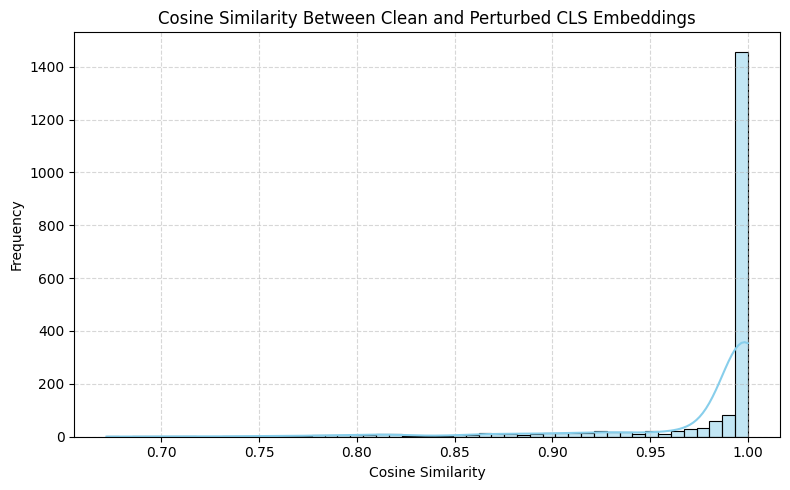

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
CSV_PATH = "results/sc_o/emotion_perturbed/bhadresh_ft_enc/cls_cosine_deletions.csv"
TITLE = "Cosine Similarity Between Clean and Perturbed CLS Embeddings"
SAVE_PLOT = "results/sc_o/emotion_perturbed/bhadresh_ft_enc/cls_cosine_hist_deletions.png"

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
sims = df["cosine_similarity"]

# === SUMMARY STATS ===
print("Summary Statistics:")
print(sims.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))
print(f"\n# samples: {len(sims)}")
print(f"Num very low similarity (< 0.5): {(sims < 0.5).sum()}")
print(f"Num very high similarity (> 0.95): {(sims > 0.95).sum()}")

# === HISTOGRAM ===
plt.figure(figsize=(8, 5))
sns.histplot(sims, bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title(TITLE)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig(SAVE_PLOT)
print(f"\nPlot saved to {SAVE_PLOT}")
plt.show()


Summary Statistics:
count    2000.000000
mean        0.853335
std         0.251121
min        -0.233638
10%         0.447469
25%         0.857603
50%         0.976826
75%         0.993212
90%         0.997679
95%         0.998803
max         0.999936
Name: cosine_similarity, dtype: float64

# samples: 2000
Num very low similarity (< 0.5): 230
Num very high similarity (> 0.95): 1251

Plot saved to results/sc_o/emotion_perturbed/bhadresh_ft/cls_cosine_hist_deletions.png


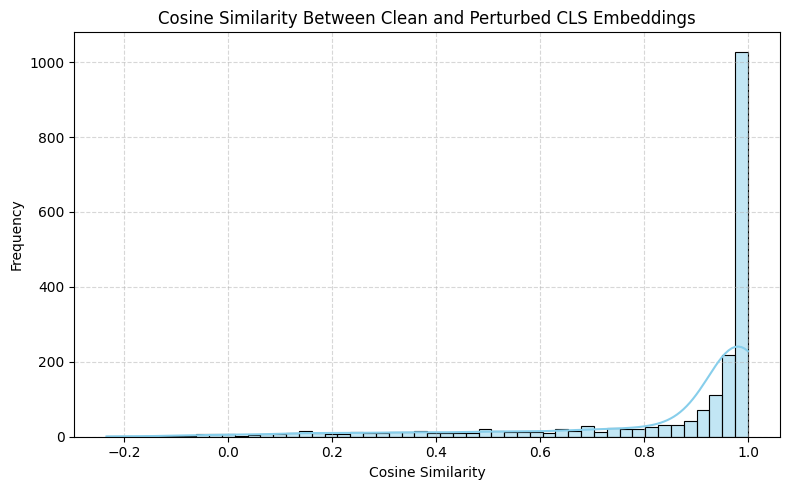

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
CSV_PATH = "results/sc_o/emotion_perturbed/bhadresh_ft/cls_cosine_deletions.csv"
TITLE = "Cosine Similarity Between Clean and Perturbed CLS Embeddings"
SAVE_PLOT = "results/sc_o/emotion_perturbed/bhadresh_ft/cls_cosine_hist_deletions.png"

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
sims = df["cosine_similarity"]

# === SUMMARY STATS ===
print("Summary Statistics:")
print(sims.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))
print(f"\n# samples: {len(sims)}")
print(f"Num very low similarity (< 0.5): {(sims < 0.5).sum()}")
print(f"Num very high similarity (> 0.95): {(sims > 0.95).sum()}")

# === HISTOGRAM ===
plt.figure(figsize=(8, 5))
sns.histplot(sims, bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title(TITLE)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig(SAVE_PLOT)
print(f"\nPlot saved to {SAVE_PLOT}")
plt.show()


Summary Statistics:
count    2000.000000
mean        0.817130
std         0.289396
min        -0.158864
10%         0.271599
25%         0.761299
50%         0.977983
75%         0.994961
90%         0.998399
95%         0.999157
max         0.999950
Name: cosine_similarity, dtype: float64

# samples: 2000
Num very low similarity (< 0.5): 335
Num very high similarity (> 0.95): 1212

Plot saved to results/sc_o/emotion_perturbed/bhadresh_orig/cls_cosine_hist_deletions.png


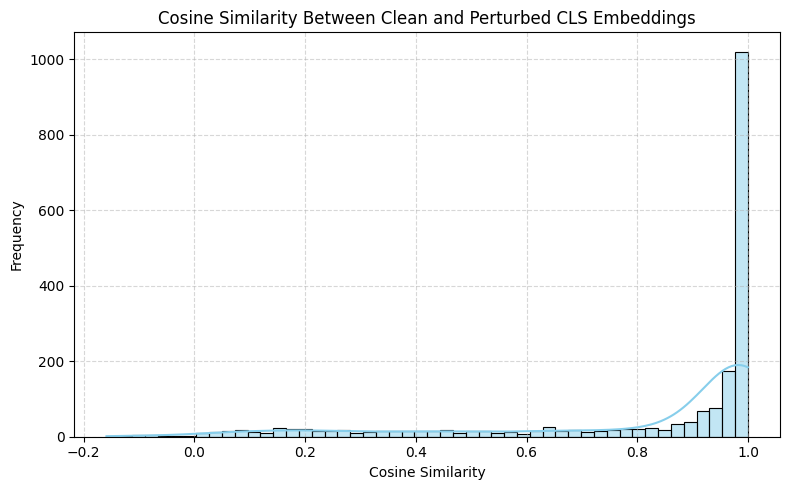

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
CSV_PATH = "results/sc_o/emotion_perturbed/bhadresh_orig/cls_cosine_deletions.csv"
TITLE = "Cosine Similarity Between Clean and Perturbed CLS Embeddings"
SAVE_PLOT = "results/sc_o/emotion_perturbed/bhadresh_orig/cls_cosine_hist_deletions.png"

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
sims = df["cosine_similarity"]

# === SUMMARY STATS ===
print("Summary Statistics:")
print(sims.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))
print(f"\n# samples: {len(sims)}")
print(f"Num very low similarity (< 0.5): {(sims < 0.5).sum()}")
print(f"Num very high similarity (> 0.95): {(sims > 0.95).sum()}")

# === HISTOGRAM ===
plt.figure(figsize=(8, 5))
sns.histplot(sims, bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title(TITLE)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig(SAVE_PLOT)
print(f"\nPlot saved to {SAVE_PLOT}")
plt.show()


In [7]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.1 MB/s eta 0:00:00


In [12]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch
from Levenshtein import distance as lev

for i in ["clean", "deletions", "homoglyphs", "invisible", "reorderings"]:

    # --- Config ---
    if (i == "clean"):
      csv_path = f"datasets/t5/ag_news/files/test/{i}_full_test.csv"
    else:
      csv_path= f"datasets/t5/ag_news/files/test/{i}_full_1to10_test.csv"         # CSV must have 'input' and 'original_text' columns
    output_path = f"{i}.csv"
    batch_size = 256
    model_id = "vlwk/t5-ft"

    # --- Load model and tokenizer ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to(device)
    model.eval()

    # --- Load data ---
    df = pd.read_csv(csv_path)
    assert "input" in df.columns and "original_text" in df.columns, "CSV must contain 'input' and 'original_text' columns"

    # --- Inference ---
    outputs, lev_dists = [], []
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["input"].iloc[i:i+batch_size].tolist()
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            output_ids = model.generate(**enc, max_length=128)
            decoded = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        outputs.extend(decoded)
        clean = df["original_text"].iloc[i:i+batch_size].tolist()
        lev_dists.extend([lev(pred, ref) for pred, ref in zip(decoded, clean)])

    # --- Save ---
    df["t5_output"] = outputs
    df["levenshtein"] = lev_dists
    df.to_csv(output_path, index=False)
    print(f"Saved to {output_path}")


100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


Saved to clean.csv


100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


Saved to deletions.csv


100%|██████████| 8/8 [00:23<00:00,  2.90s/it]


Saved to homoglyphs.csv


100%|██████████| 8/8 [00:23<00:00,  2.95s/it]


Saved to invisible.csv


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]

Saved to reorderings.csv


In [15]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch
from Levenshtein import distance as lev

for i in ["clean", "deletions", "homoglyphs", "invisible", "reorderings"]:

    # --- Config ---
    if (i == "clean"):
      csv_path = f"datasets/t5/ag_news/files/test/{i}_full_test.csv"
    else:
      csv_path= f"datasets/t5/ag_news/files/test/{i}_full_1to10_test.csv"         # CSV must have 'input' and 'original_text' columns
    output_path = f"{i}_clean.csv"
    batch_size = 256
    model_id = "vlwk/t5-agnews"

    # --- Load model and tokenizer ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to(device)
    model.eval()

    # --- Load data ---
    df = pd.read_csv(csv_path)
    assert "input" in df.columns and "original_text" in df.columns, "CSV must contain 'input' and 'original_text' columns"

    # --- Inference ---
    outputs, lev_dists = [], []
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["input"].iloc[i:i+batch_size].tolist()
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            output_ids = model.generate(**enc, max_length=128)
            decoded = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        outputs.extend(decoded)
        clean = df["original_text"].iloc[i:i+batch_size].tolist()
        lev_dists.extend([lev(pred, ref) for pred, ref in zip(decoded, clean)])

    # --- Save ---
    df["t5_output"] = outputs
    df["levenshtein"] = lev_dists
    df.to_csv(output_path, index=False)
    print(f"Saved to {output_path}")


tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

100%|██████████| 8/8 [00:23<00:00,  2.95s/it]


Saved to clean_clean.csv


100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


Saved to deletions_clean.csv


100%|██████████| 8/8 [00:23<00:00,  2.92s/it]


Saved to homoglyphs_clean.csv


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]


Saved to invisible_clean.csv


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]

Saved to reorderings_clean.csv


In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sacrebleu.metrics import BLEU
from scipy.stats import bootstrap
import os

# --- Config ---
input_dir = "datasets/t5/ag_news/files/test/"
output_csv = "t5_evaluation_summary.csv"

files = {
    "clean": "clean.csv",
    "homoglyphs": "homoglyphs.csv",
    "deletions": "deletions.csv",
    "invisible": "invisible.csv",
    "reorderings": "reorderings.csv"
}

bleu_metric = BLEU(effective_order=True)

# --- Helper: bootstrap CI ---
def ci(data, confidence=0.95):
    res = bootstrap((np.array(data),), np.mean, confidence_level=confidence, n_resamples=5000, method="basic")
    return res.confidence_interval.low, res.confidence_interval.high

# --- Process each file ---
results = []

for name, fname in files.items():
    path = fname
    df = pd.read_csv(path)

    assert "t5_output" in df.columns and "original_text" in df.columns

    # BLEU score (sentence-level)
    bleus = [bleu_metric.sentence_score(pred, [ref]).score for pred, ref in zip(df["t5_output"], df["original_text"])]
    bleu_mean = np.mean(bleus)
    bleu_ci = ci(bleus)

    # Levenshtein distance
    levs = df["levenshtein"].tolist()
    lev_mean = np.mean(levs)
    lev_ci = ci(levs)

    results.append({
        "type": name,
        "bleu": round(bleu_mean, 2),
        "bleu_ci_low": round(bleu_ci[0], 2),
        "bleu_ci_high": round(bleu_ci[1], 2),
        "levenshtein": round(lev_mean, 2),
        "lev_ci_low": round(lev_ci[0], 2),
        "lev_ci_high": round(lev_ci[1], 2)
    })

# --- Save and show ---
results_df = pd.DataFrame(results).sort_values("type")
results_df.to_csv(output_csv, index=False)
print(f"Saved evaluation summary to: {output_csv}")
results_df


Saved evaluation summary to: t5_evaluation_summary.csv


,type,bleu,bleu_ci_low,bleu_ci_high,levenshtein,lev_ci_low,lev_ci_high
0,clean,96.29,95.91,96.69,4.16,3.11,5.09
2,deletions,89.13,88.63,89.66,8.46,7.18,9.61
1,homoglyphs,89.99,89.49,90.49,8.34,7.10,9.51
3,invisible,89.74,89.24,90.26,9.14,7.81,10.37
4,reorderings,87.58,87.02,88.17,12.56,10.92,14.10


In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sacrebleu.metrics import BLEU
from scipy.stats import bootstrap
import os

# --- Config ---
input_dir = "datasets/t5/ag_news/files/test/"
output_csv = "t5_evaluation_summary.csv"

files = {
    "clean": "clean.csv",
    "homoglyphs": "homoglyphs_clean.csv",
    "deletions": "deletions_clean.csv",
    "invisible": "invisible_clean.csv",
    "reorderings": "reorderings_clean.csv"
}

bleu_metric = BLEU(effective_order=True)

# --- Helper: bootstrap CI ---
def ci(data, confidence=0.95):
    res = bootstrap((np.array(data),), np.mean, confidence_level=confidence, n_resamples=5000, method="basic")
    return res.confidence_interval.low, res.confidence_interval.high

# --- Process each file ---
results = []

for name, fname in files.items():
    path = fname
    df = pd.read_csv(path)

    assert "t5_output" in df.columns and "original_text" in df.columns

    # BLEU score (sentence-level)
    bleus = [bleu_metric.sentence_score(pred, [ref]).score for pred, ref in zip(df["t5_output"], df["original_text"])]
    bleu_mean = np.mean(bleus)
    bleu_ci = ci(bleus)

    # Levenshtein distance
    levs = df["levenshtein"].tolist()
    lev_mean = np.mean(levs)
    lev_ci = ci(levs)

    results.append({
        "type": name,
        "bleu": round(bleu_mean, 2),
        "bleu_ci_low": round(bleu_ci[0], 2),
        "bleu_ci_high": round(bleu_ci[1], 2),
        "levenshtein": round(lev_mean, 2),
        "lev_ci_low": round(lev_ci[0], 2),
        "lev_ci_high": round(lev_ci[1], 2)
    })

# --- Save and show ---
results_df = pd.DataFrame(results).sort_values("type")
results_df.to_csv(output_csv, index=False)
print(f"Saved evaluation summary to: {output_csv}")
results_df


Saved evaluation summary to: t5_evaluation_summary.csv


,type,bleu,bleu_ci_low,bleu_ci_high,levenshtein,lev_ci_low,lev_ci_high
0,clean,96.29,95.91,96.70,4.16,3.13,5.12
2,deletions,69.99,69.29,70.69,8.06,7.09,8.91
1,homoglyphs,76.77,76.14,77.41,6.72,5.78,7.55
3,invisible,65.52,64.76,66.31,8.12,7.11,8.99
4,reorderings,70.97,70.25,71.70,13.69,12.59,14.72
